# Coffee Daily Price Per Pound

## Libraries and Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (10,5)
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [3]:
coffee_raw = pd.read_csv('../Data/coffee.csv')

## Data Wrangling

In [45]:
coffee_raw.Date = pd.to_datetime(coffee_raw.Date, yearfirst=True)
coffee_raw.set_index('Date', inplace = True)
coffee = coffee_raw.asfreq('b', 'ffill')

## Exploratory Analysis

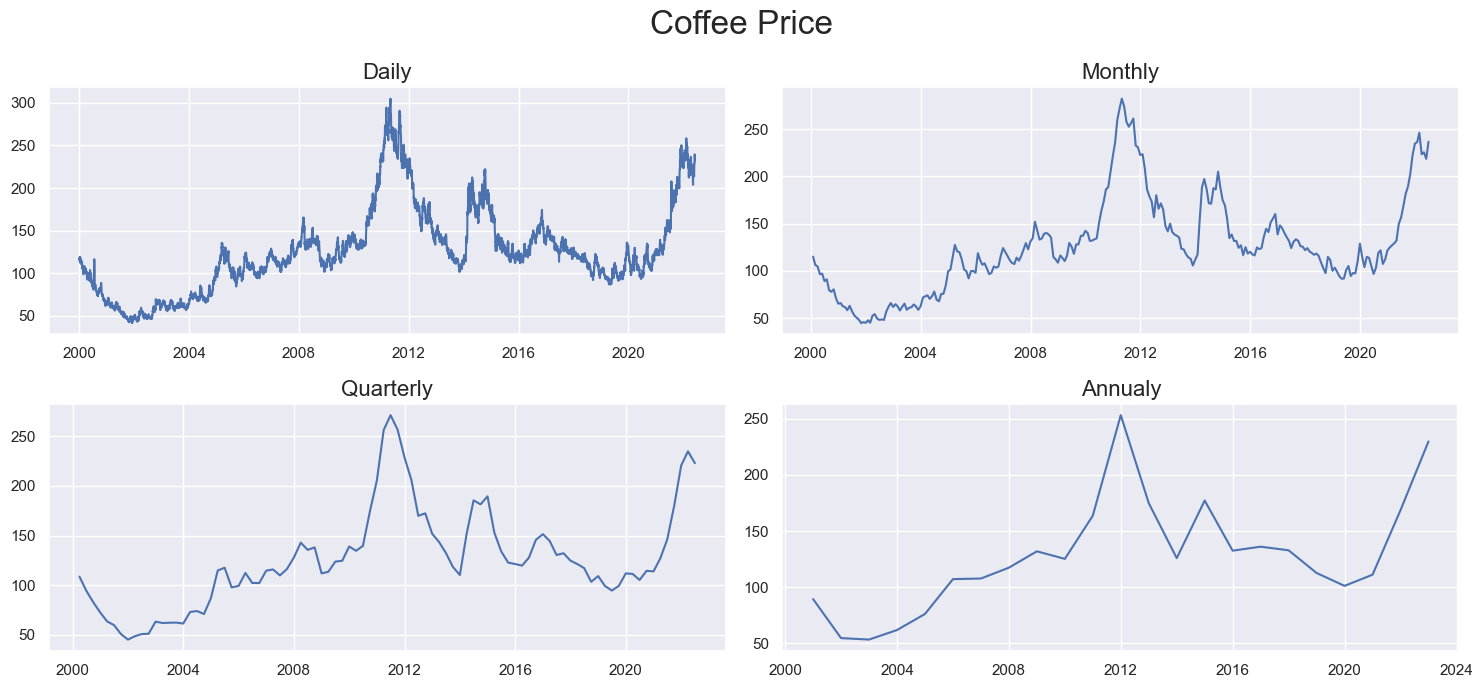

In [46]:
fig,axes = plt.subplots(2,2,figsize=[15,7])
fig.suptitle('Coffee Price',size=24)

## Resampling to Daily freq (Original Data)
axes[0,0].plot(coffee.Close)
axes[0,0].set_title("Daily",size=16)

## Resampling to Monthly freq 
axes[0,1].plot(coffee.Close.resample('M').mean())
axes[0,1].set_title("Monthly",size=16)

## Resmapling to Quarterly freq 
axes[1,0].plot(coffee.Close.resample('Q').mean())
axes[1,0].set_title('Quarterly',size=16)

## Resampling to Annualy freq
axes[1,1].plot(coffee.Close.resample('A').mean())
axes[1,1].set_title('Annualy',size=16)

plt.tight_layout()
plt.show()

### Using Statsmodels to analyse trending and seasonal prices

In [47]:
data_close_price = coffee.Close.resample('Q').mean()

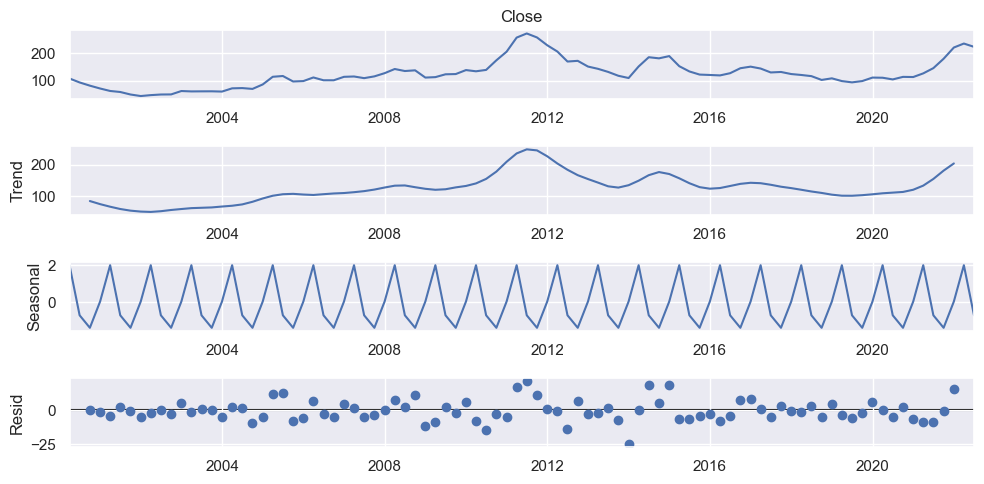

In [48]:
decompose_result = seasonal_decompose(data_close_price, model = 'additive')

## Systematic Components 
trend = decompose_result.trend
seasonal = decompose_result.seasonal

## Non-Systematic Components
residual = decompose_result.resid
decompose_result.plot();